## Load dataset

In [171]:
%load_ext autoreload
%matplotlib inline

In [172]:
# always reload modules marked with "%aimport"
%autoreload 1

In [173]:
#Load data

%store -r ili_data

In [174]:
ili_data.head()

,date,state,year,month,week,week_temp,week_prcp,ili_activity_label,ili_activity_group,a_h1,latitude,longitude
15,2011-01-08,AK,2011,1,1,-3.565308,1.930157,Level 1,Minimal,0,61.370716,-152.404419
16,2011-01-15,AK,2011,1,2,-8.022067,0.250413,Level 2,Minimal,0,61.370716,-152.404419
17,2011-01-22,AK,2011,1,3,-14.500581,0.936114,Level 3,Minimal,0,61.370716,-152.404419
18,2011-01-29,AK,2011,1,4,-9.774797,1.784652,Level 2,Minimal,0,61.370716,-152.404419
19,2011-02-05,AK,2011,1,5,-4.533875,0.342017,Level 5,Low,0,61.370716,-152.404419


In [175]:
select = ['date','state','year',
            'week_temp',
            'week_prcp',
            'latitude', 
            'longitude', 
            'month', 
            'week',
            'ili_activity_label',
            'ili_activity_group']
raw = ili_data[select].copy()
l = len(raw.columns)
print("The data contains {} features".format(l))
raw.head()

The data contains 11 features


,date,state,year,week_temp,week_prcp,latitude,longitude,month,week,ili_activity_label,ili_activity_group
15,2011-01-08,AK,2011,-3.565308,1.930157,61.370716,-152.404419,1,1,Level 1,Minimal
16,2011-01-15,AK,2011,-8.022067,0.250413,61.370716,-152.404419,1,2,Level 2,Minimal
17,2011-01-22,AK,2011,-14.500581,0.936114,61.370716,-152.404419,1,3,Level 3,Minimal
18,2011-01-29,AK,2011,-9.774797,1.784652,61.370716,-152.404419,1,4,Level 2,Minimal
19,2011-02-05,AK,2011,-4.533875,0.342017,61.370716,-152.404419,1,5,Level 5,Low


In [176]:
nstates = len(ili_data.state.unique())
print("Number of location : {}".format(nstates))

Number of location : 46


In [177]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense

# fix random seed for reproducibility
seed = 155
np.random.seed(seed)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir,'src')
sys.path.append(src_dir)

In [178]:
print(src_dir)

/Users/bbuildman/Documents/Developer/GitHub/001-BB-DL-ILI/notebooks/../src


In [179]:
# optional
from keras.callbacks import ModelCheckpoint
# specify filepath- this will write a new file for each epoch with the epoch number contained within the filename
filepath="nn_weights-{epoch:02d}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=0, 
                                             save_weights_only=False, save_best_only=False, mode='max')

In [180]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
       Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    print("The data contains {} features".format(n_vars))
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    n_vars = len(agg.columns)
    print("The reframed data contains {} features".format(n_vars))

    if dropnan:
        agg.dropna(inplace=True)
        return agg

## Prepare Dataset

In [181]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
# Encode String + Categorical value
encoder = LabelEncoder()

def label_encoder(encoder, values, col, data):
    v = values
    for name in col:
        #retrieve position in the dataframe
        pos = data.columns.get_loc(name)
        v[:,pos] = encoder.fit_transform(v[:,pos])
    return v

In [182]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

In [183]:
def data(states_label, datasets, encoder):
    n_weeks = 1
    n_features = 1
    data_states = {}
    for state in states_label:
        data = datasets[state]
        names = list(data.columns.values)
        if 'date' in names:
            data.drop(['date'], 1, inplace=True)
        values = data.values
        col = ['state','ili_activity_label','ili_activity_group']
        # encode data in database
        values = label_encoder(encoder, values, col, data)
        if(len(values)>=260):
            print(state)
            print(len(values))
            data_states[state] = values

    return data_states

In [184]:
 def reframe_data(data_states, n_weeks =1,n_features =1 ):
        reframed_data = []
        for state in data_states:
            values=data_states[state]
            # ensure all data is float
            values = values.astype('float32')
            # normalize features
            reframed = series_to_supervised(values, n_weeks, n_features)
            # drop columns we don't want to predict
            reframed.drop(reframed.columns[[11,12,13,14,15,16]], axis=1, inplace=True)
            # we are predicting ili activity
            reframed_data.append(reframed)
        return reframed_data

In [185]:
def scale_data(values):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(values)
    return scaled_data, scaler

In [186]:
def train_data(data_preprocess, n_total_years, n_train_weeks ):
    print(type(data_preprocess))
    """
    prepare the data for RNN
    """
    print("number of weeks in a year: {}".format(n_total_years))
    print("number of weeks in the training set : {}".format(n_train_weeks))
    train_features = []
    train_label = []
    test_features = []
    test_label = []
    print(len(data_preprocess))
    for data in data_preprocess:
        values = data.head(n_total_years).values
        train = values[:n_train_weeks, :]
        test = values[n_train_weeks:, :]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:,-1]
        test_X, test_y = test[:, :-1], test[:, -1]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        #print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
        train_features.append(train_X)
        train_label.append(train_y)
        test_features.append(test_X)
        test_label.append(test_y)
    return train_features, train_label, test_features, test_label

In [187]:
#we put everything together
#sepate by states
datasets = {}
states_label = ili_data.state.unique()
for s in states_label:
    datasets[s] = raw[(raw.state == s)]
    
    
print len(datasets)

46


In [188]:
temp_data = data(states_label, datasets, encoder) 
print(len(temp_data))

/Users/bbuildman/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


AK
292
AL
285
AR
281
AZ
295
CA
295
CO
293
CT
277
GA
295
HI
295
IL
290
IN
295
KY
295
MN
290
MO
295
NE
268
NY
295
OH
273
OK
274
PA
295
SC
261
SD
269
TX
295
UT
293
VA
289
WA
295
WI
284
WV
295
27


In [189]:
temp_reframed = reframe_data(temp_data)
print(len(temp_reframed))

The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The reframed data contains 20 features
The data contains 10 features
The 

In [190]:
n_total_years = 5*52 # equivalent of 5 years of data
n_train_weeks = 3*52 # equivalent of 3 years of data
print("number of weeks in a year: {}".format(n_total_years))
print("number of weeks in the training set : {}".format(n_train_weeks))

number of weeks in a year: 260
number of weeks in the training set : 156


In [191]:
train_features, train_label, test_features, test_label = train_data(temp_reframed, n_total_years, n_train_weeks )

<type 'list'>
number of weeks in a year: 260
number of weeks in the training set : 156
27


In [192]:
print "Number of training samples: %d"%train_features[0].shape[0]
print "Number of test samples: %d"%test_features[0].shape[0]
print "Timestep: %d"%train_features[0].shape[1]
print "Features: %d"%train_features[0].shape[2]

Number of training samples: 156
Number of test samples: 104
Timestep: 1
Features: 13


In [193]:
%autoreload
import time
import os

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Input, concatenate
from keras.models import Model

#allow to use time distributed content
from keras.layers import TimeDistributed
from keras.callbacks import TensorBoard

import numpy as np
from numpy import concatenate

from math import sqrt
import matplotlib.pyplot as plt

In [ ]:
data_dim = 13
timesteps = 1
batch_size = 52
states = temp_data.keys()

def simple_rnn_model(data_dim = 13,timesteps = 1,batch_size = 52,states = temp_data.keys(), n_neurons = 50):
    #dataLength =  4 weeks
    stateInputs = {}
    stateLayers = []
    i = 0
    for state in states:
        inputName = "{}_input".format(state)
        stateInputs[inputName] = Input(shape=(timesteps,data_dim),
                                       batch_shape =(batch_size, timesteps, data_dim), 
                                       name=inputName)
    for state in stateInputs:
        stateL = LSTM(n_neurons, return_sequences=False, stateful=True,
                            batch_input_shape=(batch_size, timesteps, data_dim))(stateInputs[state])
        stateLayers.append(stateL)
     
    #combined the output
    output = keras.layers.concatenate(stateLayers)
    output = Dense(1, activation='relu', name='wheighthedAverage_output')(output)
    stateInput = stateInputs.values()
    
    model = Model(inputs = stateInput, outputs = [output])
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return model

In [ ]:
my_first_rnn = simple_rnn_model(data_dim,timesteps,batch_size,states)

In [ ]:
processed_dir = os.path.join(os.getcwd(),os.pardir, 'models')
processed_dir

In [197]:
plot_model_history

In [ ]:
# verbose=0 suppresses the file writing message
# note that the fit method expects a list of callbacks
start = time.time()
my_first_rnn_fitted = my_first_rnn.fit(
    train_features,
    train_label[0], #label for the targeted state
    validation_data= (
        test_features,
        test_label[0] ),
    epochs=2000,
    verbose=0,
    shuffle = False,
    batch_size=52,
    callbacks=[checkpoint],
    initial_epoch=0
)
end = time.time()
print "Model took %0.2f seconds to train"%(end - start)

In [205]:
# [loss, accuracy]
my_first_rnn.evaluate(test_features, test_label[0],batch_size=52, verbose=0)

[0.46379945427179337, 0.82692307233810425]

In [200]:
# train_data.size % batch_size = 0
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

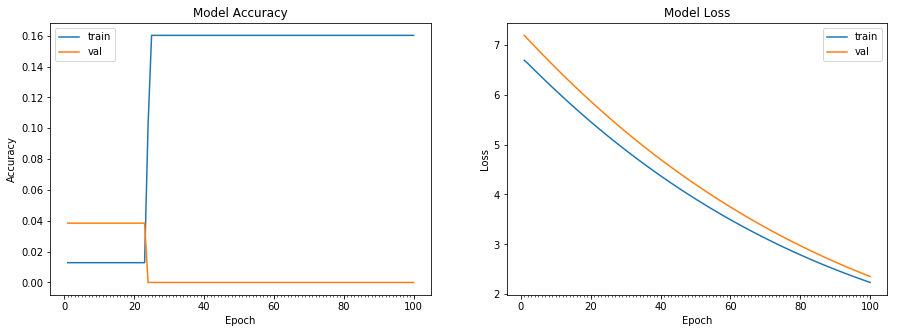

In [201]:
plot_model_history(my_first_rnn_fitted)

In [202]:
def plot_model_history2(my_first_nn_fitted):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.plot(range(len(my_first_nn_fitted.history['loss'])), my_first_nn_fitted.history['loss'],linestyle='-', color='blue',label='Training', lw=2)
    ax1.plot(range(len(np.array(test_over_time)[:,0])), np.array(test_over_time)[:,0], linestyle='-', color='green',label='Test', lw=2)
    ax2.plot(range(len(my_first_nn_fitted.history['acc'])), my_first_nn_fitted.history['acc'],linestyle='-', color='blue',label='Training', lw=2)
    ax2.plot(range(len(np.array(test_over_time)[:,1])), np.array(test_over_time)[:,1], linestyle='-', color='green',label='Test', lw=2)
    leg = ax1.legend(bbox_to_anchor=(0.7, 0.9), loc=2, borderaxespad=0.,fontsize=13)
    ax1.set_xticklabels('')
    #ax1.set_yscale('log')
    ax2.set_xlabel('# Epochs',fontsize=14)
    ax1.set_ylabel('Loss',fontsize=14)
    ax2.set_ylabel('Accuracy',fontsize=14)
    plt.show()

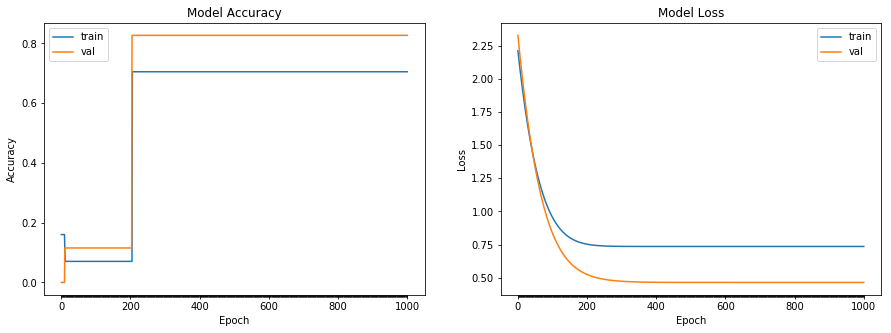

In [206]:
plot_model_history(my_first_rnn_fitted)

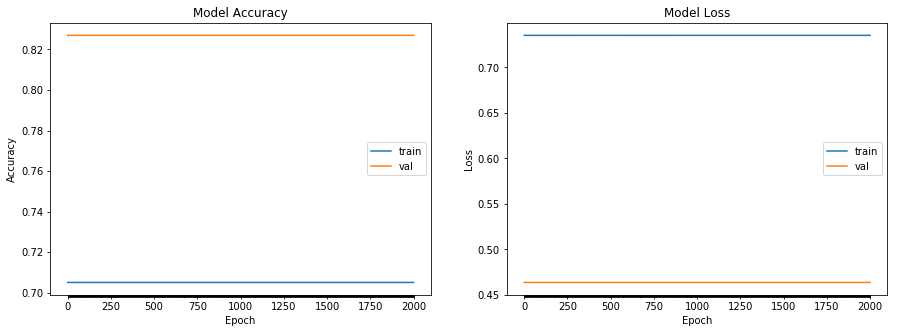

In [208]:
plot_model_history(my_first_rnn_fitted)